# 第 7 章：RNA-Seq カウントデータの処理
----

## 7.1 準備

### 7.1.1 RNA-Seq とは
RNA-Seq とは、mRNA や miRNA の配列をシークエンスして、発現量の定量や新規転写産物の同定を行う手法である。シークエンスで得られたデータ（リード）は、次のステップで解析する。
1. リードのトリミング
2. ゲノム配列へのマッピング
3. マッピングされたリード数を数える
4. サンプルごとの総リード数の違いや、遺伝子配列長の違いを補正（正規化）
5. 遺伝子ごとの発現量を同定、比較

この章では上記ステップのうち 4 以降を扱い、主に pandas を使って処理を行う。

### 7.1.2 この章で用いる RNA-Seq データ
この章では、異なる 2 条件で培養された酵母 (Saccharomyces cerevisiae) の RNA-Seq データを使用する。この RNA-Seq データは、DDBJ の SRA データベースにアクセッション番号 SRR453566 から SRR453571 の 6 つのデータとして存在している。
- SRR453566, SRR453567, SRR453568 : 通常のグルコース濃度培地による Batch 培養のサンプルから得られた
- SRR453569, SRR453570, SRR453571 : 低グルコース濃度を維持した培地による Chemostat 培養のサンプルから得られた

いずれも Biological triplicates になっている。

### 7.1.3 本章で使用するデータファイル
- counts.txt
- gene_id_product.tsv

## 7.2 データファイルの読み込みとアノテーション
### 7.2.1 カウントデータ

In [1]:
# 7-2 : 各種インポート
import pandas as pd
import numpy as np

In [2]:
# 7-3 : ファイルのパス指定
count_file = 'counts.txt'
gene_id_product_file = 'gene_id_product.tsv'

In [3]:
# 7-4 : ファイル読み込み
df = pd.read_table(count_file, index_col=0, skiprows=1)

- skiprows : DataFrame に読み込まない行 (ファイルの先頭行を 0 として数える)を数字で指定する。リストで指定することもできる
  - `skiprows=1` の代わりに `header=1` としても良い
- index_col : インデックスとして用いる列を数字で指定する

### 7.2.2 データの概観

In [4]:
# 7-5 : 読み込んだファイルの確認
df.head()

,Chr,Start,End,Strand,Length,SRR453566.sorted.bam,SRR453567.sorted.bam,SRR453568.sorted.bam,SRR453569.sorted.bam,SRR453570.sorted.bam,SRR453571.sorted.bam
Geneid,,,,,,,,,,,
gene_0001,NC_001133.9,1807,2169,-,363,0,2,6,0,0,1
gene_0002,NC_001133.9,2480,2707,+,228,0,0,0,0,0,0
gene_0003,NC_001133.9,7235,9016,-,1782,0,0,0,0,0,0
gene_0004,NC_001133.9,11565,11951,-,387,0,0,0,0,0,0
gene_0005,NC_001133.9,12046,12426,+,381,2,8,10,6,7,18


In [5]:
# 7-6 : 特定の列 (Start の列) だけ確認
df.Start.head()

Geneid
gene_0001     1807
gene_0002     2480
gene_0003     7235
gene_0004    11565
gene_0005    12046
Name: Start, dtype: object

In [6]:
# 7-7 : ファイルの行数と列数の確認
df.shape

(6420, 11)

### 7.2.3 列名を変更する

In [7]:
# 7-8 : 列名を変更するための辞書の宣言
names = {'SRR453566.sorted.bam': 'batch_1',
         'SRR453567.sorted.bam': 'batch_2',
         'SRR453568.sorted.bam': 'batch_3',
         'SRR453569.sorted.bam': 'chemostat_1',
         'SRR453570.sorted.bam': 'chemostat_2',
         'SRR453571.sorted.bam': 'chemostat_3',}

In [8]:
# 7-9 : 列名の変更
df = df.rename(mapper=names, axis=1)

In [9]:
# 7-10 : 変更できたか確認
df.head()

,Chr,Start,End,Strand,Length,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
Geneid,,,,,,,,,,,
gene_0001,NC_001133.9,1807,2169,-,363,0,2,6,0,0,1
gene_0002,NC_001133.9,2480,2707,+,228,0,0,0,0,0,0
gene_0003,NC_001133.9,7235,9016,-,1782,0,0,0,0,0,0
gene_0004,NC_001133.9,11565,11951,-,387,0,0,0,0,0,0
gene_0005,NC_001133.9,12046,12426,+,381,2,8,10,6,7,18


### 7.2.4 ミトコンドリア上の遺伝子を除く

In [10]:
# 7-11 : ミトコンドリア上の遺伝子に一致しないものだけ取り出す
df = df[df.Chr != 'NC_001224.1']

In [11]:
# 7-12 : 処理できたか確認 (正しければデータ件数は 6,394 件)
df.shape

(6394, 11)

### 7.2.5 アノテーションファイルの読み込み

In [12]:
# 7-13 : ファイルの読み込み
gene_products = pd.read_table(gene_id_product_file, index_col=0, names=['gene_id', 'product'])

ヘッダー名を左から `gene_id`, `product` とする。

In [13]:
# 7-14 : ファイルの確認
gene_products.head()

,product
gene_id,
gene_0001,seripauperin PAU8
gene_0002,hypothetical protein
gene_0003,putative permease SEO1
gene_0004,hypothetical protein
gene_0005,hypothetical protein


### 7.2.6 カウントデータと description を連結する

In [14]:
# 7-15 : カウントデータとアノテーションファイルの結合
df_with_product = gene_products.join(df)

merge を使った場合  
`pd.merge(gene_products, df, left_index=True, right_index=True)`  
concat を使った場合  
`pd.concat([gene_products, df], axis=1, join='inner')`

In [15]:
# 7-16 : 結合したデータフレームの確認
df_with_product.head()

,product,Chr,Start,End,Strand,Length,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,,,,,,,
gene_0001,seripauperin PAU8,NC_001133.9,1807,2169,-,363,0,2,6,0,0,1
gene_0002,hypothetical protein,NC_001133.9,2480,2707,+,228,0,0,0,0,0,0
gene_0003,putative permease SEO1,NC_001133.9,7235,9016,-,1782,0,0,0,0,0,0
gene_0004,hypothetical protein,NC_001133.9,11565,11951,-,387,0,0,0,0,0,0
gene_0005,hypothetical protein,NC_001133.9,12046,12426,+,381,2,8,10,6,7,18


### 7.2.7 カウントデータ部分の切り出し

In [16]:
# 7-17 : raw カウントの部分の切り出し
df_count = df_with_product[['batch_1', 'batch_2', 'batch_3', 'chemostat_1', 'chemostat_2', 'chemostat_3']]

スライスで指定する場合は `df_with_product.iloc[:, 6:12]`

### 7.2.8 ファイルの保存

In [17]:
# 7-17.5 : 作業ディレクトリに output ディレクトリの用意
%mkdir output

mkdir: output: File exists


In [18]:
# 7-18 : アノテーション付きカウントデータを保存
df_with_product.to_csv('output/count_preprocessed.tsv', sep='\t')

In [19]:
# 7-19 : raw カウントのデータを保存
df_count.to_csv('output/count_raw.tsv', sep='\t')

In [20]:
%%bash
head output/count_raw.tsv

# 7-20 : 保存したデータの確認
# マジックコマンドはセルの先頭にないと動かない

gene_id	batch_1	batch_2	batch_3	chemostat_1	chemostat_2	chemostat_3
gene_0001	0	2	6	0	0	1
gene_0002	0	0	0	0	0	0
gene_0003	0	0	0	0	0	0
gene_0004	0	0	0	0	0	0
gene_0005	2	8	10	6	7	18
gene_0006	0	0	0	0	0	0
gene_0007	0	0	0	0	0	0
gene_0008	0	0	0	0	0	0
gene_0009	32	37	33	43	63	84


## 7.3 カウントデータの正規化
### 7.3.1 リード数で正規化（RPM / FPM）

In [21]:
# 7-21 : df_count を別の DataFrame としてコピー
df_tmp = df_count.copy()

In [22]:
# 7-22 : リード数の合計を確認
sum_count = df_tmp.sum()
sum_count

batch_1        4565008
batch_2        6253117
batch_3        4524000
chemostat_1    3073975
chemostat_2    3869518
chemostat_3    4902464
dtype: int64

In [23]:
# 7-23 : 100 万リードあたりのカウント数に揃える
df_tmp = 10**6 * df_tmp / sum_count
df_tmp.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.000000,0.319840,1.326260,0.00000,0.000000,0.203979
gene_0002,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
gene_0003,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
gene_0004,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
gene_0005,0.438115,1.279362,2.210433,1.95187,1.809011,3.671623


`**` は冪乗演算子

In [24]:
# 7-24 : リード数の合計が 100 万に揃っているか確認
df_tmp.sum()

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

In [25]:
# 7-25 : FPM 正規化を関数化
def normalize_per_million_reads(df):
    sum_count = df.sum()
    return 10**6 * df / sum_count

In [26]:
# 7-26 : 実際に関数を使ってみる
df_count_fpm = normalize_per_million_reads(df_count)

In [27]:
# 7-27 : リード数の合計が揃っているか確認
df_count_fpm.sum()

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

In [28]:
# 7-28 : FPM 正規化を行った結果を保存
df_count_fpm.to_csv('output/count_fpm.tsv', sep='\t')

### 7.3.2 遺伝子長による正規化（RPKM / FPKM）

FPM をさらに遺伝子長で割って FPKM を求める  
FPKM : fragments per kilobase of exon per million reads mapped  
RPKM : reads per kilobase of exon per million reads mapped (single-end の場合)  
この 2 つはほぼ同じ意味で用いられる

In [29]:
# 7-29 : テスト用に df_count_fpm をコピーしておく
df_tmp = df_count_fpm.copy()

In [30]:
# 7-30 : アノテーションをつけたカウントデータから遺伝子の長さを抽出しておく
gene_length = df_with_product['Length']

FPM 正規化したカウントデータを書く遺伝子の長さで割るが、次のように書くと縦方向にブロードキャストされてしまうためうまくいかない  
`df_tmp / gene_length`  
これを 1 列ずつ計算することはできる  
`df_tmp['batch_1'] / gene_length * 10**3`

#### for ループを使う方法

In [31]:
%%timeit
# 7-31 : for ループで回すと列名が取得できるのでそれを利用
df_tmp = df_count_fpm.copy()
for col_name in df_tmp:
    df_tmp[col_name] = df_tmp[col_name] / gene_length * 10**3

1.63 ms ± 8.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
# 7-32 : 中身の確認
df_tmp.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.000000,0.319840,1.326260,0.00000,0.000000,0.203979
gene_0002,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
gene_0003,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
gene_0004,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
gene_0005,0.438115,1.279362,2.210433,1.95187,1.809011,3.671623


In [33]:
%%timeit
# 7-33 : iteritems() を使ってもできる
df_tmp = df_count_fpm.copy()
for col_name, col in df_tmp.iteritems():
    df_tmp[col_name] = col / gene_length * 10**3

1.61 ms ± 2.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### データフレームを転置してから計算する方法
1. FPM 正規化したカウントデータを `df_tmp` としてコピー
2. `df_tmp` を転置して FPM を遺伝子長で割り、1000 をかける
3. もう一度転置する

In [34]:
%%timeit
# 7-34 : データフレームを転置してから計算
df_tmp = df_count_fpm.copy()
df_tmp = df_tmp.T / gene_length * 10**3
df_tmp = df_tmp.T

994 µs ± 5.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### apply() を使い各列に関数を適用する方法

In [35]:
# 7-35 : 列を入力とし、各要素を遺伝子長で割る行う関数の定義
def divide_by_length(S):
    return S / gene_length * 10**3

In [36]:
%%timeit
# 7-36 : 定義した関数の適用
df_tmp = df_count_fpm.copy().apply(divide_by_length)

1.75 ms ± 9.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### divide() を使用する方法

In [37]:
%%timeit
# 7-37 : divide() を使う方法
df_tmp = df_count_fpm.copy()
df_tmp = df_tmp.divide(gene_length, axis='index') * 10**3

300 µs ± 3.98 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
# 7-38 : データフレームを転置させて計算する関数の定義
def normalize_per_kilobase(df, gene_length):
    df_tmp = df.copy()
    df_tmp = (df.T * 10**3 / gene_length).T
    return df_tmp

In [39]:
# 7-39 : 関数の適用、結果確認
df_count_fpkm = normalize_per_kilobase(df_count_fpm, gene_length)
df_count_fpkm.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.000000,0.881103,3.653609,0.000000,0.00000,0.561926
gene_0002,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0003,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0004,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0005,1.149909,3.357905,5.801662,5.123019,4.74806,9.636806


In [40]:
# 7-40 : 結果の保存
df_count_fpkm.to_csv('output/count_fpkm.tsv', sep='\t')

### 7.3.3 TPM 正規化
TPM : transcripts per million  
長さ 1,000bp あたりのリード数を求めてから、総リード数を 100 万に揃える

In [41]:
# 7-41 : カウントファイルの準備
df_tmp = df_count.copy()

In [42]:
# 7-42 : TPM 正規化
df_tmp = normalize_per_kilobase(df_tmp, gene_length)  # 長さ 1,000bp あたりのリード数
df_tmp = normalize_per_million_reads(df_tmp)  # 総リード数を 100 万に揃える

In [43]:
# 7-43 : 結果の確認
df_tmp.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.00000,0.734587,3.129839,0.000000,0.000000,0.504810
gene_0002,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
gene_0003,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
gene_0004,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
gene_0005,0.94849,2.799529,4.969954,4.689762,4.372026,8.657291


In [44]:
# 7-44 : 合計が 100 万になっているか確認
df_tmp.sum()

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

In [45]:
# 7-45 : TPM 正規化を関数化
def normalize_tpm(df, gene_length):
    df_tmp = df.copy()
    df_tmp = normalize_per_kilobase(df_tmp, gene_length)
    df_tmp = normalize_per_million_reads(df_tmp)
    return df_tmp

In [46]:
# 7-46 : 関数の適用
df_count_tmp = normalize_tpm(df_count, gene_length)

In [47]:
# 7-47 : 結果の確認
df_count_tmp.sum()

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

In [48]:
# 7-48 : 結果の保存
df_count_tmp.to_csv('output/count_tpm.tsv', sep='\t')

### 7.3.4 NumPy を用いた高速バージョンの比較

In [49]:
%%timeit
normalize_tpm(df_count, gene_length)

# 7-49 : pandas で定義した TPM 正規化の実行時間を確認

1.71 ms ± 3.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [50]:
# 7-50 : Numpy での実装に必要なデータの抽出
counts = df_count.values
length = gene_length.values

1. 遺伝子の長さで正規化（行方向でブロードキャストするため、length を reshape しておく）
2. 次に、カウント数の各列の合計を求める
3. 100 万カウントに揃える

In [51]:
%%timeit
counts_tmp = counts / length.reshape(-1, 1) * 1000
sum_count = counts_tmp.sum(axis=0)
tpm = counts_tmp / sum_count *1000000

# 7-51 : NumPy を用いた TPM 正規化の実行時間確認

98.2 µs ± 558 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## 7.4 発現変動遺伝子の抽出

In [52]:
# 7-52 : batch 培養の平均と chemostat 培養の平均を df_count_tpm に追加
df_count_tmp['batch'] = (df_count_tmp['batch_1'] + df_count_tmp['batch_2'] + df_count_tmp['batch_3']) / 3
df_count_tmp['chemostat'] = (df_count_tmp['chemostat_1'] + df_count_tmp['chemostat_2'] + df_count_tmp['chemostat_3']) / 3

In [53]:
# 7-53 : 発現変動を 2 を底とした対数値として求める
df_count_tmp['log2fold'] = df_count_tmp['chemostat'] / (df_count_tmp['batch'] + 10**-6)  # 0 での除算を防ぐために分母に微小な値を加える
df_count_tmp['log2fold'] = df_count_tmp['log2fold'].apply(np.log2)
df_count_tmp.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3,batch,chemostat,log2fold
gene_id,,,,,,,,,
gene_0001,0.00000,0.734587,3.129839,0.000000,0.000000,0.504810,1.288142,0.168270,-2.936443
gene_0002,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-inf
gene_0003,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-inf
gene_0004,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-inf
gene_0005,0.94849,2.799529,4.969954,4.689762,4.372026,8.657291,2.905991,5.906359,1.023238


In [54]:
# 7-54 : 必要部分のみ抜き出して product 名をつけて、gene_products に結合
diff_ex = df_count_tmp[['batch', 'chemostat', 'log2fold']]  # この 3 つが必要
diff_ex = diff_ex.join(gene_products)
diff_ex.head()

,batch,chemostat,log2fold,product
gene_id,,,,
gene_0001,1.288142,0.168270,-2.936443,seripauperin PAU8
gene_0002,0.000000,0.000000,-inf,hypothetical protein
gene_0003,0.000000,0.000000,-inf,putative permease SEO1
gene_0004,0.000000,0.000000,-inf,hypothetical protein
gene_0005,2.905991,5.906359,1.023238,hypothetical protein


In [55]:
# 7-55 : カウント数が 0 であるデータを除く
diff_ex = diff_ex[diff_ex['batch'] > 0]
diff_ex = diff_ex[diff_ex['chemostat'] > 0]

In [56]:
# 7-56 : 行数の確認
diff_ex.shape

(5857, 4)

In [57]:
# 7-57 : 結果の確認
diff_ex.head()

,batch,chemostat,log2fold,product
gene_id,,,,
gene_0001,1.288142,0.168270,-2.936443,seripauperin PAU8
gene_0005,2.905991,5.906359,1.023238,hypothetical protein
gene_0009,1.424695,3.627256,1.348225,flocculin FLO9
gene_0010,8.211912,155.846213,4.246261,glutamate dehydrogenase (NADP(+)) GDH3
gene_0011,14.270889,155.994499,3.450348,putative dehydrogenase BDH2


In [58]:
# 7-58 : log2fold の降順に並び替え
diff_ex = diff_ex.sort_values('log2fold', ascending=False)

In [59]:
# 7-59 : 発現変動遺伝子の上位を表示
diff_ex.head()  # chemostat > batch の上位 5 番目まで表示

,batch,chemostat,log2fold,product
gene_id,,,,
gene_2989,0.428753,1469.082090,11.742478,Rgi2p
gene_4740,3.101195,5075.124519,10.676403,Sip18p
gene_4667,4.944971,4658.135852,9.879575,Spg4p
gene_4237,0.961310,708.223065,9.524985,hypothetical protein
gene_5965,7.232487,5295.812440,9.516144,Gre1p


In [60]:
# 7-60 : 発現変動遺伝子の上位を表示
diff_ex.tail()  # batch > chemostat の上位 5 番目まで表示

,batch,chemostat,log2fold,product
gene_id,,,,
gene_0314,10.570903,1.105484,-3.257349,ADP/ATP carrier protein AAC3
gene_2429,2.082786,0.181792,-3.518158,hypothetical protein
gene_2725,784.525221,66.820686,-3.553453,hexose transporter HXT4
gene_5487,77.913513,6.244048,-3.641320,hypothetical protein
gene_1320,812.668223,46.017423,-4.142414,hexose transporter HXT3


## 7.5 TPM 正規化したデータのクラスタリング

In [61]:
# 7-61 : matplotlib と SciPy のモジュールを import
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [62]:
# 7-62 : 各サンプルの TPM 正規化カウントデータだけにする
tpm_t = df_count_tmp.T
tpm_t = tpm_t.drop(['batch', 'chemostat', 'log2fold'])

In [63]:
# 7-63 : ユークリッド距離、Ward 法を用いてクラスタリング
linkage_result = linkage(tpm_t, method='ward', metric='euclidean')

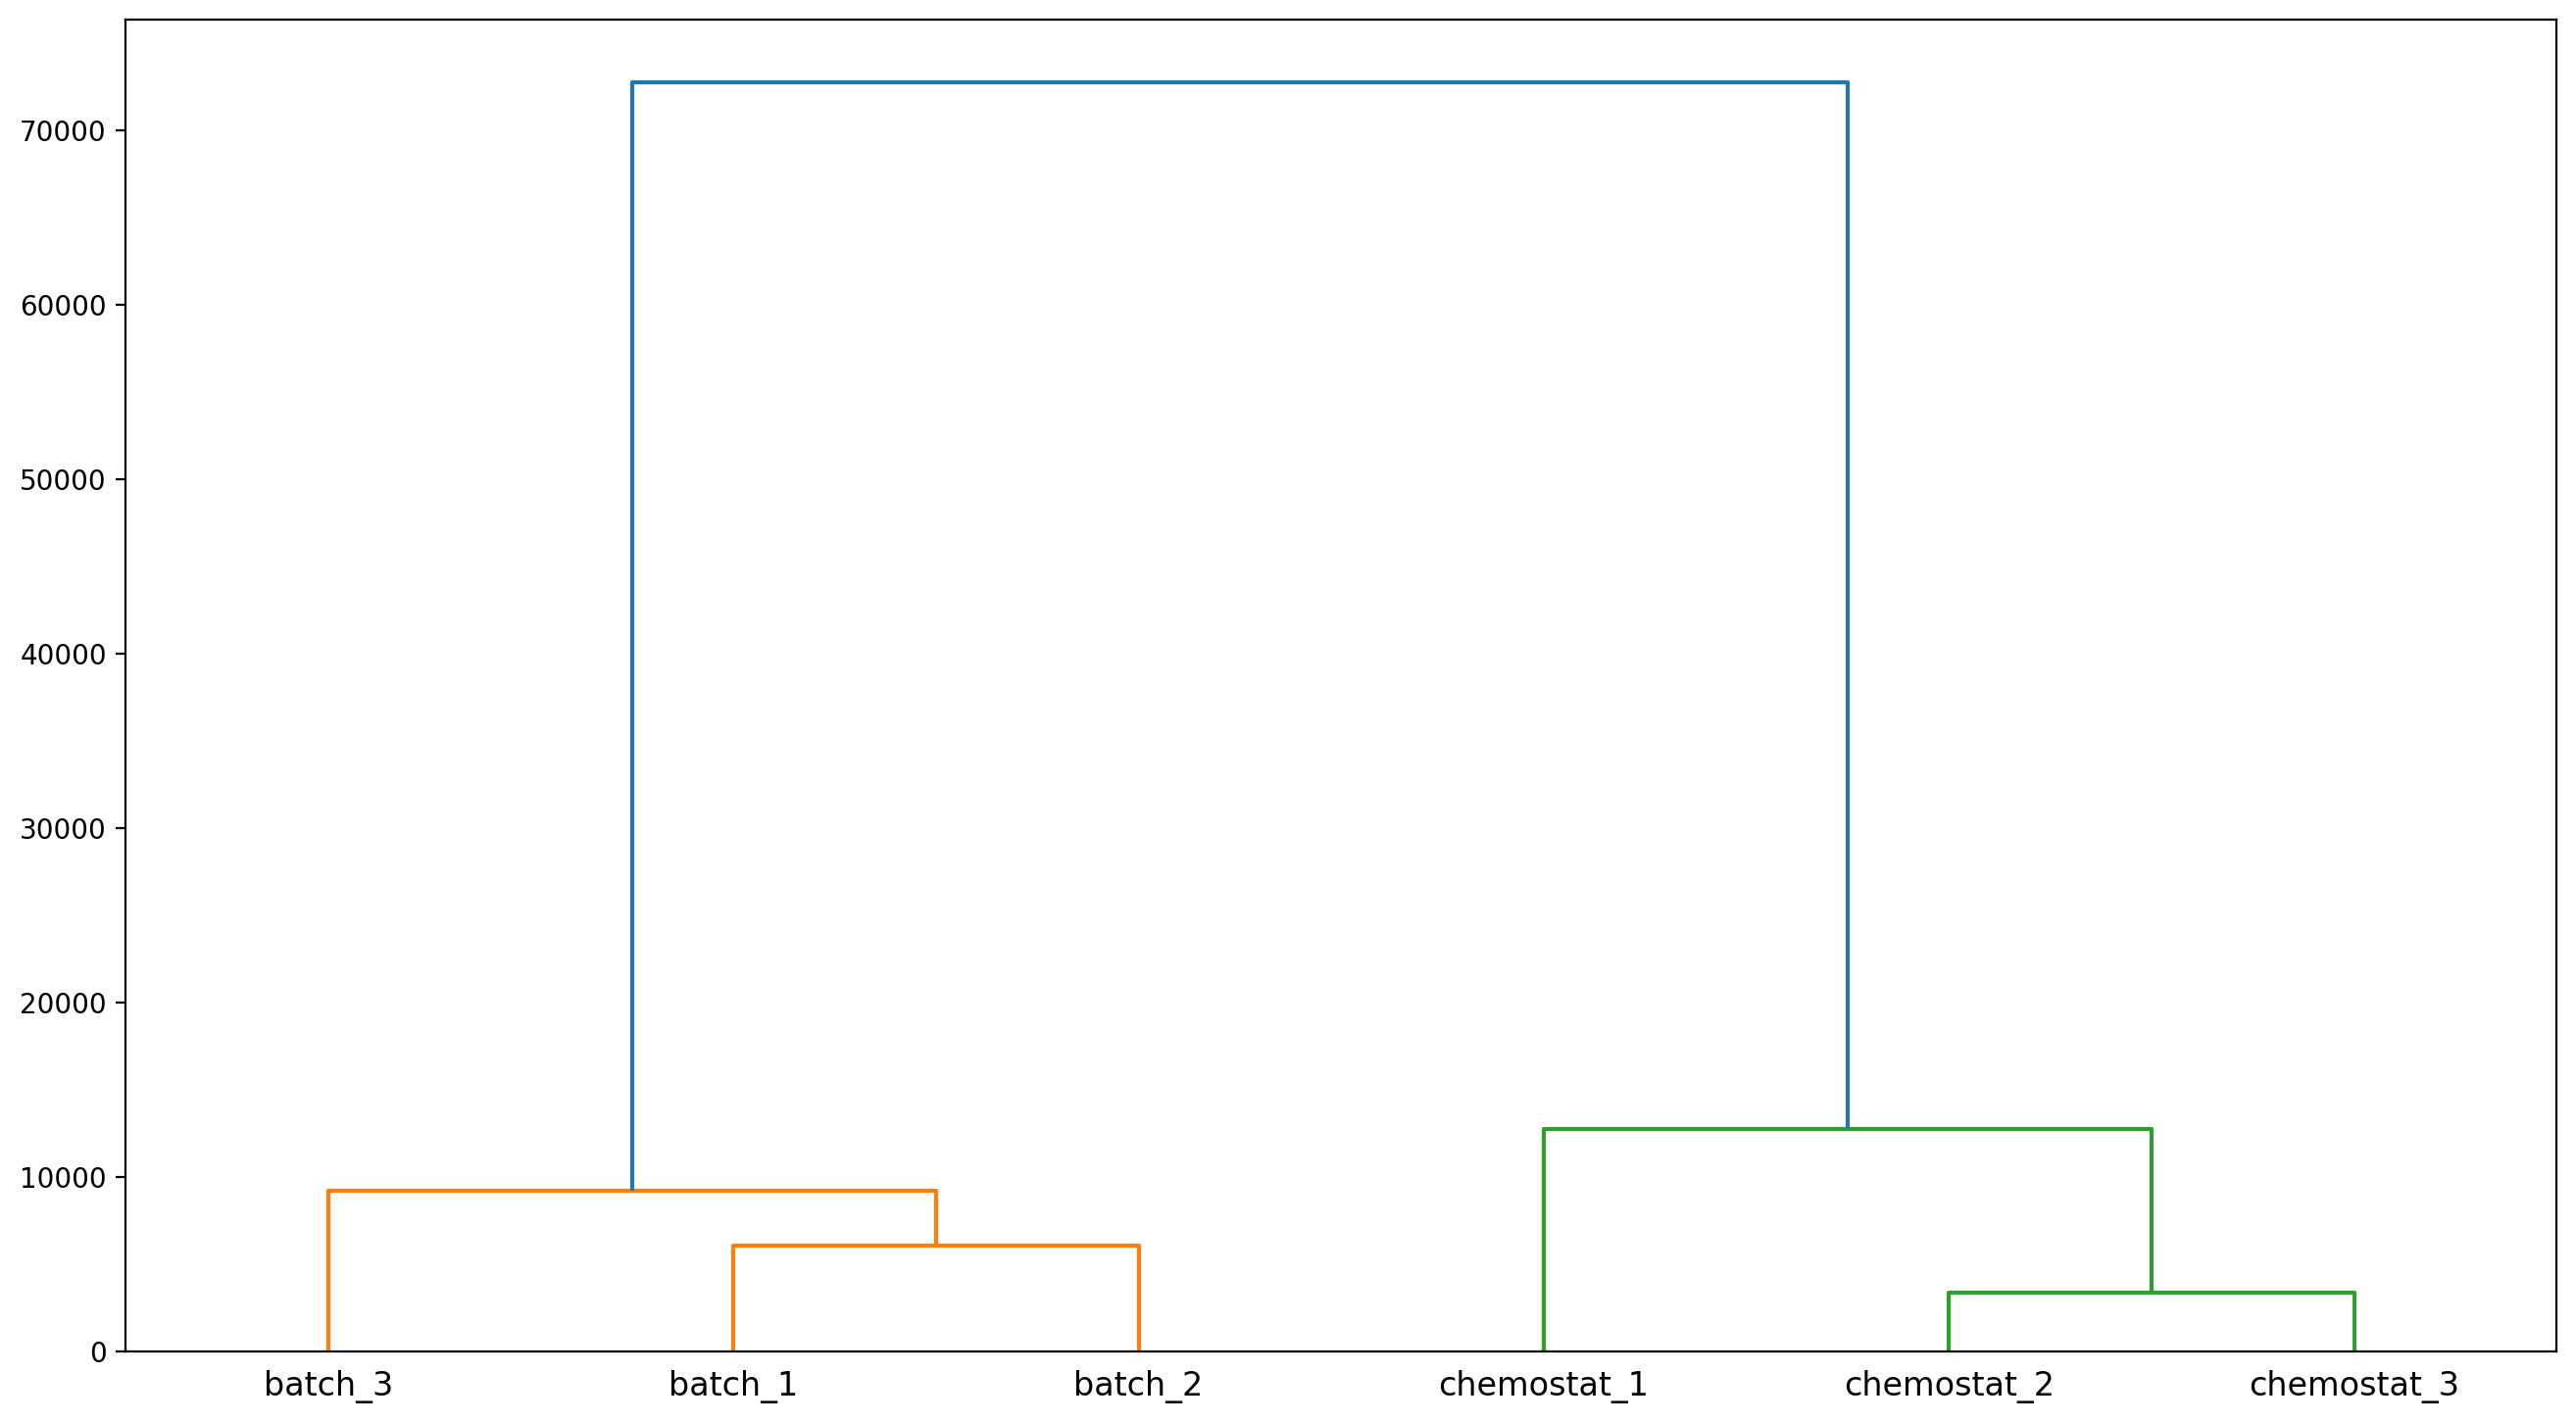

In [64]:
# 7-64 : デンドログラムを描く
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result, labels=list(tpm_t.index))
plt.show()

デンドログラム（樹形図）：クラスター分析において、逐次的に標本がグループ化される様子を木の枝のような線で表したもの